In [1]:
from backtest import run_classical_methods

INTERVALS = [
            (2017, y, y + 1)
            for y in range(2020, 2024)
        ]

REFERENCE_EXPERIMENT = "stock_tft_cp21_len252_notime_div_v1"

features_file_path = "Data/full_data.csv"

run_classical_methods(features_file_path, INTERVALS, REFERENCE_EXPERIMENT)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'results\\long_only'

In [4]:
import os
import pandas as pd
import numpy as np
from functools import reduce
from backtest import run_all_windows


HP_MINIBATCH_SIZE = [64, 128, 256]
TICKERS = ['ADM', 'ALB', 'ALCO', 'AMZN', 'BA', 'BAC', 'BG', 'BKNG', 'C', 'CAH', 'CMCSA', 'DHI', 'DIS', 'DUK', 'FCX', 'FDP',
           'GOOGL', 'GPC', 'GS', 'GWW', 'HSIC', 'INTC', 'JPM', 'KO', 'LEN', 'LMNR', 'MCK', 'META', 'NEE', 'NEM', 'NVR',
           'PEP', 'PG', 'PHM', 'RGLD', 'SCCO', 'T', 'TOL', 'TWX', 'VZ', 'WFC', 'WMT']
MODLE_PARAMS = {
    "architecture": "TFT",
    "total_time_steps": 252,
    "early_stopping_patience": 25,
    "multiprocessing_workers": 32,
    "num_epochs": 200,
    "early_stopping_patience": 25,
    "fill_blank_dates": False,
    "split_tickers_individually": True,
    "random_search_iterations": 25,
    "evaluate_diversified_val_sharpe": True,
    "train_valid_ratio": 0.90,
    "time_features": False,
    "force_output_sharpe_length": 0,
}


TEST_MODE = False
ASSET_CLASS_MAPPING = dict(zip(TICKERS, ["STOCK"] * len(TICKERS)))
TRAIN_VALID_RATIO = 0.9
TIME_FEATURES = False
FORCE_OUTPUT_SHARPE_LENGTH = None
EVALUATE_DIVERSIFIED_VAL_SHARPE = True
NAME = "stock"

In [7]:
folder_path = "Data/Finished_Datasets/"
combined_data = []

for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        data = pd.read_csv(file_path)

        combined_data.append(data)


combined_df = pd.concat(combined_data, ignore_index=True)

combined_df = combined_df.drop(columns=["close", "srs"])


combined_df.to_csv("Data/full_data.csv", index=False)

In [2]:
def run_test(experiment: str, train_start: int, test_start: int, test_end: int, test_window_size: int, num_repeats: int):

    if experiment == "LSTM":
        architecture = "LSTM"
        lstm_time_steps = 63
        changepoint_lbws = [21]
    elif experiment == "TFT":
        architecture = "TFT"
        lstm_time_steps = 252
        changepoint_lbws = [21]
    elif experiment == "TFT-SHORT":
        architecture = "TFT"
        lstm_time_steps = 63
        changepoint_lbws = [21]
    else:
        raise BaseException("Invalid experiment.")

    versions = range(1, 1 + num_repeats) if not TEST_MODE else [1]

    experiment_prefix = (
        NAME
        + ("_TEST" if TEST_MODE else "")
        + ("" if TRAIN_VALID_RATIO == 0.90 else f"_split{int(TRAIN_VALID_RATIO * 100)}")
    )

    cp_string = (
        "none"
        if not changepoint_lbws
        else reduce(lambda x, y: str(x) + str(y), changepoint_lbws)
    )
    time_string = "time" if TIME_FEATURES else "notime"
    _project_name = f"{experiment_prefix}_{architecture.lower()}_cp{cp_string}_len{lstm_time_steps}_{time_string}_{'div' if EVALUATE_DIVERSIFIED_VAL_SHARPE else 'val'}"

    if FORCE_OUTPUT_SHARPE_LENGTH:
        _project_name += f"_outlen{FORCE_OUTPUT_SHARPE_LENGTH}"
    _project_name += "_v"

    for v in versions:
        PROJECT_NAME = _project_name + str(v)

        intervals = [
            (train_start, y, y + test_window_size)
            for y in range(test_start, test_end)
        ]


        params = MODLE_PARAMS.copy()
        params["total_time_steps"] = lstm_time_steps
        params["architecture"] = architecture
        params["evaluate_diversified_val_sharpe"] = EVALUATE_DIVERSIFIED_VAL_SHARPE
        params["train_valid_ratio"] = TRAIN_VALID_RATIO
        params["time_features"] = TIME_FEATURES
        params["force_output_sharpe_length"] = FORCE_OUTPUT_SHARPE_LENGTH


        if TEST_MODE:
            params["num_epochs"] = 1
            params["random_search_iterations"] = 2

        features_file_path = "Data/full_data.csv"

        run_all_windows(
            PROJECT_NAME,
            features_file_path,
            intervals,
            params,
            changepoint_lbws,
            ASSET_CLASS_MAPPING,
            [32, 64, 128] if lstm_time_steps == 252 else HP_MINIBATCH_SIZE,
            test_window_size,
        )



In [5]:
run_test("TFT-SHORT", 2017, 2020, 2024, 1, 1)

Trial 8 Complete [00h 01m 38s]
sharpe: 4.293720395798558

Best sharpe So Far: 4.293720395798558
Total elapsed time: 00h 06m 01s

Search: Running Trial #9

Hyperparameter    |Value             |Best Value So Far 
hidden_layer_size |5                 |80                
dropout_rate      |0.5               |0.2               
max_gradient_norm |100               |0.01              
learning_rate     |0.01              |0.0001            
batch_size        |64                |256               

Epoch 1/200


KeyboardInterrupt: 

In [ ]:
raw_data = pd.read_csv("Data/full_data.csv", index_col=0, parse_dates=True)
raw_data.rename(columns={'date.1': 'date'}, inplace=True)
raw_data["date"] = raw_data["date"].astype("datetime64[ns]")

In [ ]:
df = raw_data.dropna()
df = df[df["year"] >= 2017].copy()
years = df["year"]

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import os
os.environ['CUDA_HOME'] = r"C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2"
os.environ['PATH'] += r";C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin"
os.environ['PATH'] += r";C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/extras/CUPTI/libx64"
os.environ['PATH'] += r";C:/tools/cuda/bin"

In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices("GPU")
if physical_devices:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Memory growth set for GPUs.")
    except RuntimeError as e:
        print("Error setting memory growth:", e)
else: print("No GPUs found.")

Memory growth set for GPUs.


In [ ]:
import tensorflow as tf

print(tf.__version__)

2.10.0


In [ ]:
test = "results\stocks_TEST_lstm_cp21_len63_notime_div_v1\2019-2020\hp\experiment_stocks_TEST_lstm_cp21_len63_notime_div_v1\trial_411433bdbcbf8165d1cbd9e69e534202\checkpoints\epoch_0\checkpoint_temp/part-00000-of-00001.data-00000-of-00001.tempstate1022316393468577740"

In [ ]:
os.path.normpath(test)

'results\\stocks_TEST_lstm_cp21_len63_notime_div_v1\x819-2020\\hp\\experiment_stocks_TEST_lstm_cp21_len63_notime_div_v1\trial_411433bdbcbf8165d1cbd9e69e534202\\checkpoints\\epoch_0\\checkpoint_temp\\part-00000-of-00001.data-00000-of-00001.tempstate1022316393468577740'

In [4]:
df2 = pd.read_csv('Data/full_data.csv')

df2['target_returns'] = df2.groupby('ticker')['daily_returns'].shift(-1)

df2.to_csv("Data/full_data_2.csv", index=False)

In [35]:
import pandas as pd

# Load the data
file_path = 'results/stock_tft_cp21_len63_notime_div_v1/2021-2022/captured_returns_sw.csv'
df = pd.read_csv(file_path)

# Check the first few rows to understand the structure


df = df.rename(columns={'identifier': 'ticker', 'time': 'date'})
absolute_sum = df.groupby('date')['position'].apply(lambda x: x.abs().sum())

#df = df[['date', 'ticker', 'position']]


df2 = pd.read_csv('Data/full_data.csv')
df2 = df2[['date', 'ticker', 'daily_returns']]


return_data = df.merge(df2, on=['date', 'ticker'])

return_data = return_data.merge(absolute_sum.rename('abs_sum'), on='date')

return_data['normalized_position'] = return_data['position'] / return_data['abs_sum']

#return_data['captured_returns'] = return_data['normalized_position'] * return_data['daily_returns']


#total_captured_returns = (1 + srs).cumprod()

# Output the cumulative returns over time
#df = df.merge(absolute_sum.rename('abs_sum'), on='time')

#df['normalized_position'] = df['position'] / df['abs_sum']
#df['new_captured_returns'] = df['position'] * df['returns']

#srs = return_data.dropna().groupby('date')["captured_returns"].sum() 

srs = return_data.dropna().groupby('date')["captured_returns"].sum() / 41
total_captured_returns = (1 + srs).cumprod()


total_captured_returns

date
2021-01-04    1.008252
2021-01-05    0.981891
2021-01-06    0.980251
2021-01-07    0.983042
2021-01-08    0.982818
                ...   
2021-12-27    1.700500
2021-12-28    1.684691
2021-12-29    1.686616
2021-12-30    1.682712
2021-12-31    1.752255
Name: captured_returns, Length: 252, dtype: float64

In [23]:
from empyrical import annual_return

In [34]:
file_path = 'results/stock_tft_cp21_len63_notime_div_v1/2021-2022/captured_returns_sw.csv'
df = pd.read_csv(file_path)

num_identifiers = None
if not num_identifiers:
    num_identifiers = len(df.dropna()["identifier"].unique())

print(num_identifiers)
    
srs = df.dropna().groupby("time")["captured_returns"].sum() / num_identifiers

annual_return(srs)

41


0.7522553514168295

-0.9999938554827763

In [29]:
df[df['ticker'] == "META"]

,Unnamed: 0,ticker,date,returns,position,captured_returns,daily_vol,captured_returns_0_5_bps,captured_returns_1_0_bps,captured_returns_1_5_bps,captured_returns_2_0_bps,captured_returns_2_5_bps,captured_returns_3_0_bps
6804,6804,META,2021-01-04,0.038704,0.998743,0.038655,0.012285,0.038655,0.038655,0.038655,0.038655,0.038655,0.038655
6805,6805,META,2021-01-05,-0.148778,0.998770,-0.148595,0.011969,-0.148596,-0.148597,-0.148598,-0.148599,-0.148600,-0.148601
6806,6806,META,2021-01-06,0.103203,0.998824,0.103082,0.012587,0.103080,0.103078,0.103076,0.103074,0.103072,0.103070
6807,6807,META,2021-01-07,-0.021476,0.998838,-0.021451,0.012770,-0.021451,-0.021452,-0.021453,-0.021453,-0.021454,-0.021454
6808,6808,META,2021-01-08,-0.204201,0.998842,-0.203965,0.012371,-0.203966,-0.203967,-0.203968,-0.203970,-0.203971,-0.203972
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7051,7051,META,2021-12-27,0.000503,0.998609,0.000502,0.014471,0.000501,0.000499,0.000497,0.000496,0.000494,0.000492
7052,7052,META,2021-12-28,-0.042624,0.998245,-0.042550,0.014001,-0.042551,-0.042552,-0.042553,-0.042554,-0.042555,-0.042556
7053,7053,META,2021-12-29,0.019069,0.998307,0.019037,0.013678,0.019036,0.019035,0.019034,0.019034,0.019033,0.019032
7054,7054,META,2021-12-30,-0.110644,0.998269,-0.110452,0.013243,-0.110454,-0.110455,-0.110456,-0.110457,-0.110458,-0.110459


In [5]:
df2 = pd.read_csv('Data/full_data.csv')

df2

,Unnamed: 0,date,ticker,daily_returns,daily_vol,target_returns,norm_daily_return,norm_monthly_return,norm_quarterly_return,norm_biannual_return,...,macd_16_48,macd_32_96,day_of_week,day_of_month,week_of_year,month_of_year,year,date.1,cp_rl_21,cp_score_21
0,0,2017-02-02,ADM,0.005026,0.013287,0.000000,0.378290,-0.782247,-0.559804,0.009158,...,0.979929,1.789347,3,2,5,2,2017,2017-02-02,0.524036,0.905511
1,1,2017-02-03,ADM,0.000000,0.013067,0.000493,0.000000,-0.767795,-0.667111,0.038966,...,0.925244,1.806076,4,3,5,2,2017,2017-02-03,0.066960,0.764505
2,2,2017-02-06,ADM,0.000682,0.012853,0.009520,0.053061,-0.649172,-0.704763,-0.067054,...,0.881689,1.838061,0,6,6,2,2017,2017-02-06,0.619347,0.947613
3,3,2017-02-07,ADM,0.012949,0.012861,-0.018618,1.006785,-0.049322,-0.486452,0.010891,...,0.892004,1.875989,1,7,6,2,2017,2017-02-07,0.667561,0.912485
4,4,2017-02-08,ADM,-0.025342,0.013452,0.001293,-1.883889,-0.467629,-0.714626,-0.137287,...,0.780288,1.873311,2,8,6,2,2017,2017-02-08,0.579210,0.657956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78248,78248,2023-12-21,WMT,0.007091,0.013242,0.008528,0.535510,-0.112075,-0.442458,-0.028562,...,-0.771321,0.779996,3,21,51,12,2023,2023-12-21,0.333020,0.670246
78249,78249,2023-12-22,WMT,0.011951,0.013214,-0.001096,0.904411,0.211405,-0.375370,0.069571,...,-0.739761,0.767631,4,22,51,12,2023,2023-12-22,0.380051,0.648526
78250,78250,2023-12-26,WMT,-0.001532,0.012998,0.006832,-0.117865,0.037652,-0.363258,0.085179,...,-0.713329,0.752617,1,26,52,12,2023,2023-12-26,0.428099,0.614016
78251,78251,2023-12-27,WMT,0.009398,0.012898,-0.001438,0.728688,0.119795,-0.231946,0.113394,...,-0.662151,0.748356,2,27,52,12,2023,2023-12-27,0.475733,0.606752


In [ ]:
df2['Unnamed: 0']

In [7]:
df2 = df2.drop(columns="Unnamed: 0")

In [8]:
df2

,date,ticker,daily_returns,daily_vol,target_returns,norm_daily_return,norm_monthly_return,norm_quarterly_return,norm_biannual_return,norm_annual_return,...,macd_16_48,macd_32_96,day_of_week,day_of_month,week_of_year,month_of_year,year,date.1,cp_rl_21,cp_score_21
0,2017-02-02,ADM,0.005026,0.013287,0.000000,0.378290,-0.782247,-0.559804,0.009158,1.495770,...,0.979929,1.789347,3,2,5,2,2017,2017-02-02,0.524036,0.905511
1,2017-02-03,ADM,0.000000,0.013067,0.000493,0.000000,-0.767795,-0.667111,0.038966,1.370921,...,0.925244,1.806076,4,3,5,2,2017,2017-02-03,0.066960,0.764505
2,2017-02-06,ADM,0.000682,0.012853,0.009520,0.053061,-0.649172,-0.704763,-0.067054,1.431406,...,0.881689,1.838061,0,6,6,2,2017,2017-02-06,0.619347,0.947613
3,2017-02-07,ADM,0.012949,0.012861,-0.018618,1.006785,-0.049322,-0.486452,0.010891,1.660587,...,0.892004,1.875989,1,7,6,2,2017,2017-02-07,0.667561,0.912485
4,2017-02-08,ADM,-0.025342,0.013452,0.001293,-1.883889,-0.467629,-0.714626,-0.137287,1.377813,...,0.780288,1.873311,2,8,6,2,2017,2017-02-08,0.579210,0.657956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78248,2023-12-21,WMT,0.007091,0.013242,0.008528,0.535510,-0.112075,-0.442458,-0.028562,0.355011,...,-0.771321,0.779996,3,21,51,12,2023,2023-12-21,0.333020,0.670246
78249,2023-12-22,WMT,0.011951,0.013214,-0.001096,0.904411,0.211405,-0.375370,0.069571,0.376638,...,-0.739761,0.767631,4,22,51,12,2023,2023-12-22,0.380051,0.648526
78250,2023-12-26,WMT,-0.001532,0.012998,0.006832,-0.117865,0.037652,-0.363258,0.085179,0.436745,...,-0.713329,0.752617,1,26,52,12,2023,2023-12-26,0.428099,0.614016
78251,2023-12-27,WMT,0.009398,0.012898,-0.001438,0.728688,0.119795,-0.231946,0.113394,0.479344,...,-0.662151,0.748356,2,27,52,12,2023,2023-12-27,0.475733,0.606752


In [9]:
df2.to_csv("Data/full_data.csv", index=False)

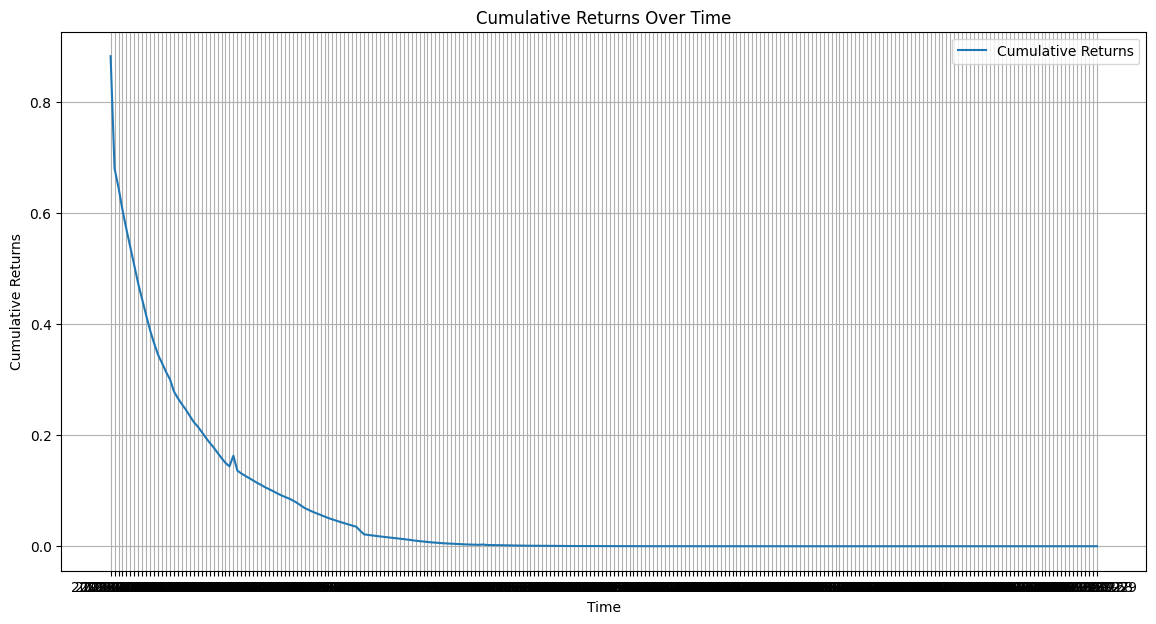

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(total_captured_returns, label='Cumulative Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.show()